# 1. Define the Problem

The goal is to predict and minimize carbon emissions in supply chain logistics by optimizing routes, transport modes, or warehouse operations.

Objective: Develop a model that predicts carbon footprint for logistics operations and suggests ways to reduce it.

Example target: CO₂ emissions (in kg CO₂e per shipment).

Possible use case: Selecting the most sustainable shipping route or transport mode (truck, rail, air, sea) while balancing cost and time

# **2**. Data Collection and Understanding

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [26]:
data = pd.read_csv('supplychain_dataset.csv')

In [27]:
data.shape

(2215, 10)

In [28]:
print("Preview of dataset:")
data.head()

Preview of dataset:


,Shipment_ID,Route_Distance_km,Weight_kg,Transport_Mode,Fuel_Type,Fuel_Consumption_L,CO2_Emissions,Region,Delivery_Time_days,Cost_USD
0,SHP2466,833.98,2585.10,Rail,Diesel,NaN,1286.27,East,6.4,676.89
1,SHP2418,805.69,2955.81,Ship,Electric,421.88,1817.94,North,3.9,817.72
2,SHP1581,416.94,1480.19,NaN,NaN,269.39,1333.59,South,8.2,761.55
3,SHP2517,626.16,3846.33,Truck,Petrol,406.12,750.83,East,6.6,1075.20
4,SHP2231,226.04,3076.98,Truck,Electric,434.52,1058.46,North,3.4,858.95


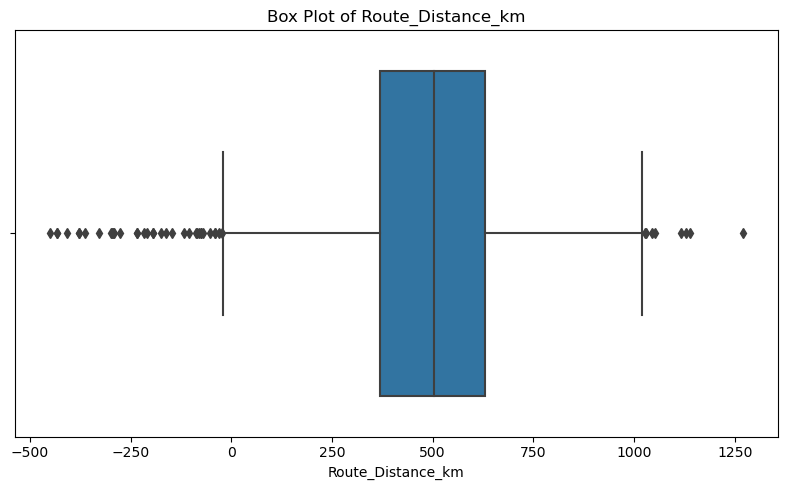

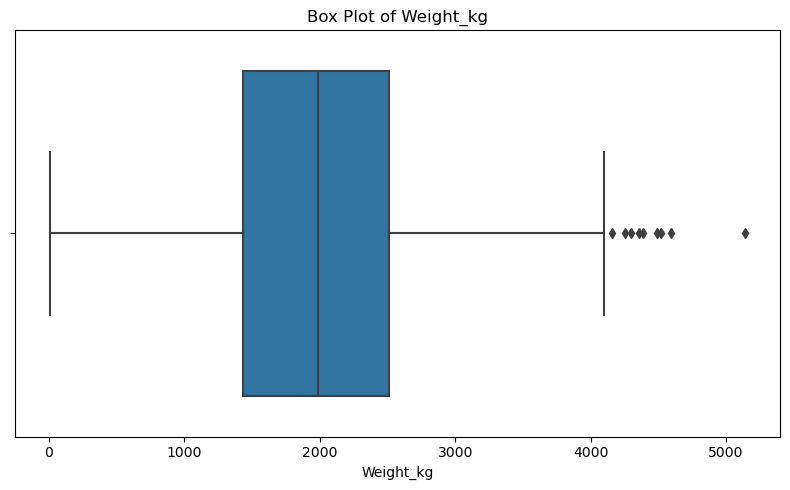

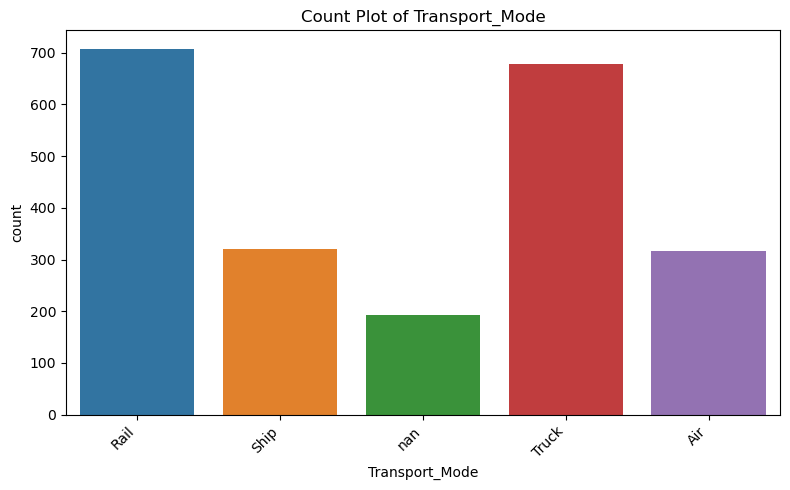

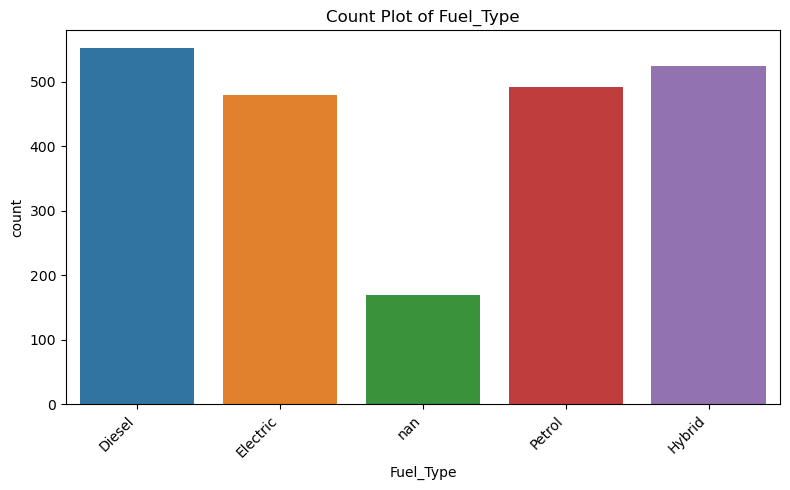

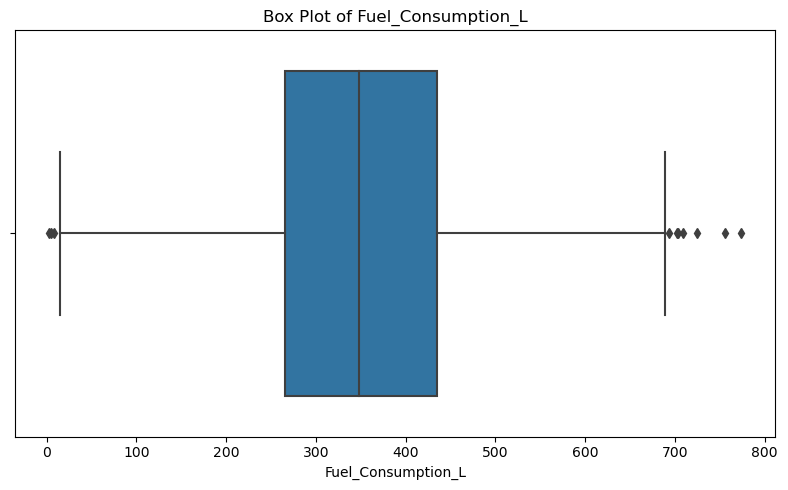

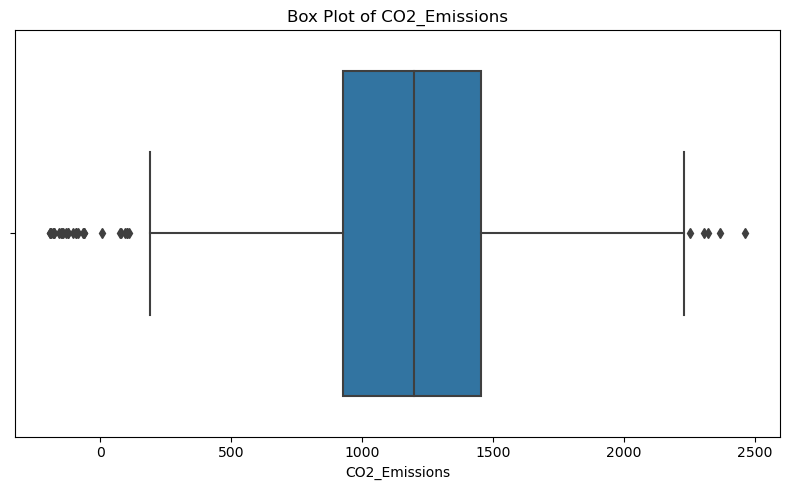

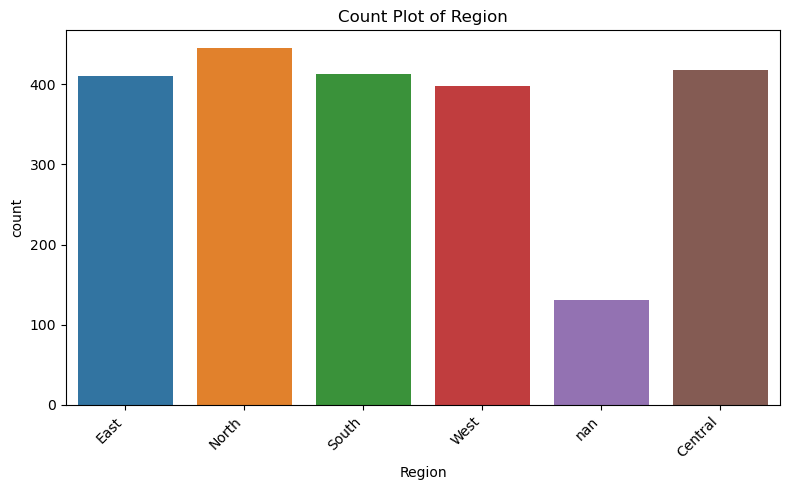

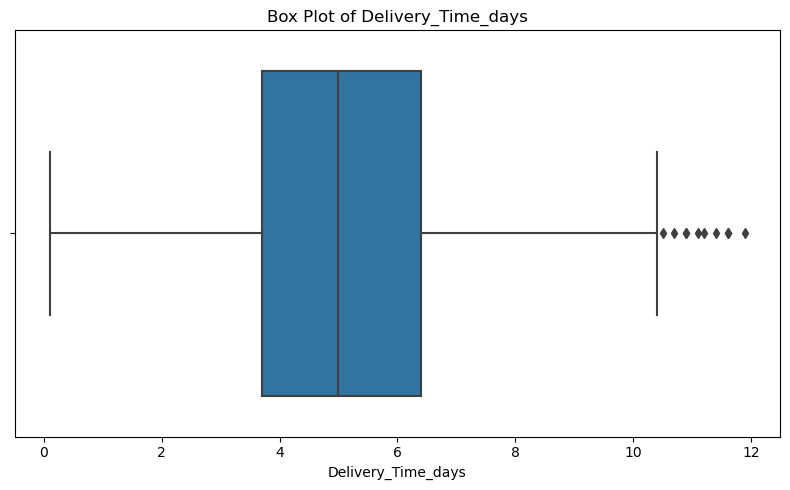

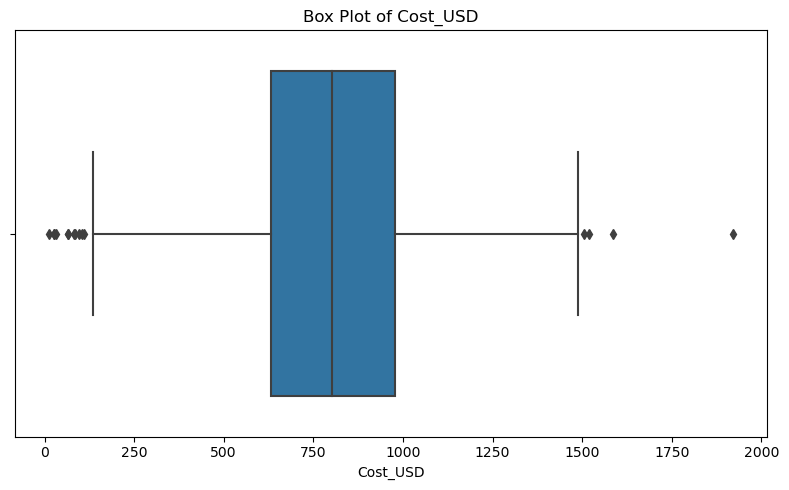

In [29]:
#outliers detection
features_to_plot = [
    'Route_Distance_km', 'Weight_kg', 'Transport_Mode', 'Fuel_Type',
    'Fuel_Consumption_L', 'CO2_Emissions', 'Region', 'Delivery_Time_days', 'Cost_USD'
]

for column in features_to_plot:
    plt.figure(figsize=(8, 5))
    # If numeric -> boxplot for outlier detection
    if pd.api.types.is_numeric_dtype(data[column]):
        sns.boxplot(x=data[column].dropna())
        plt.title(f'Box Plot of {column}')
        plt.xlabel(column)
    else:
        # If categorical -> show counts instead of boxplot
        sns.countplot(x=data[column].astype(str))
        plt.title(f'Count Plot of {column}')
        plt.xlabel(column)
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

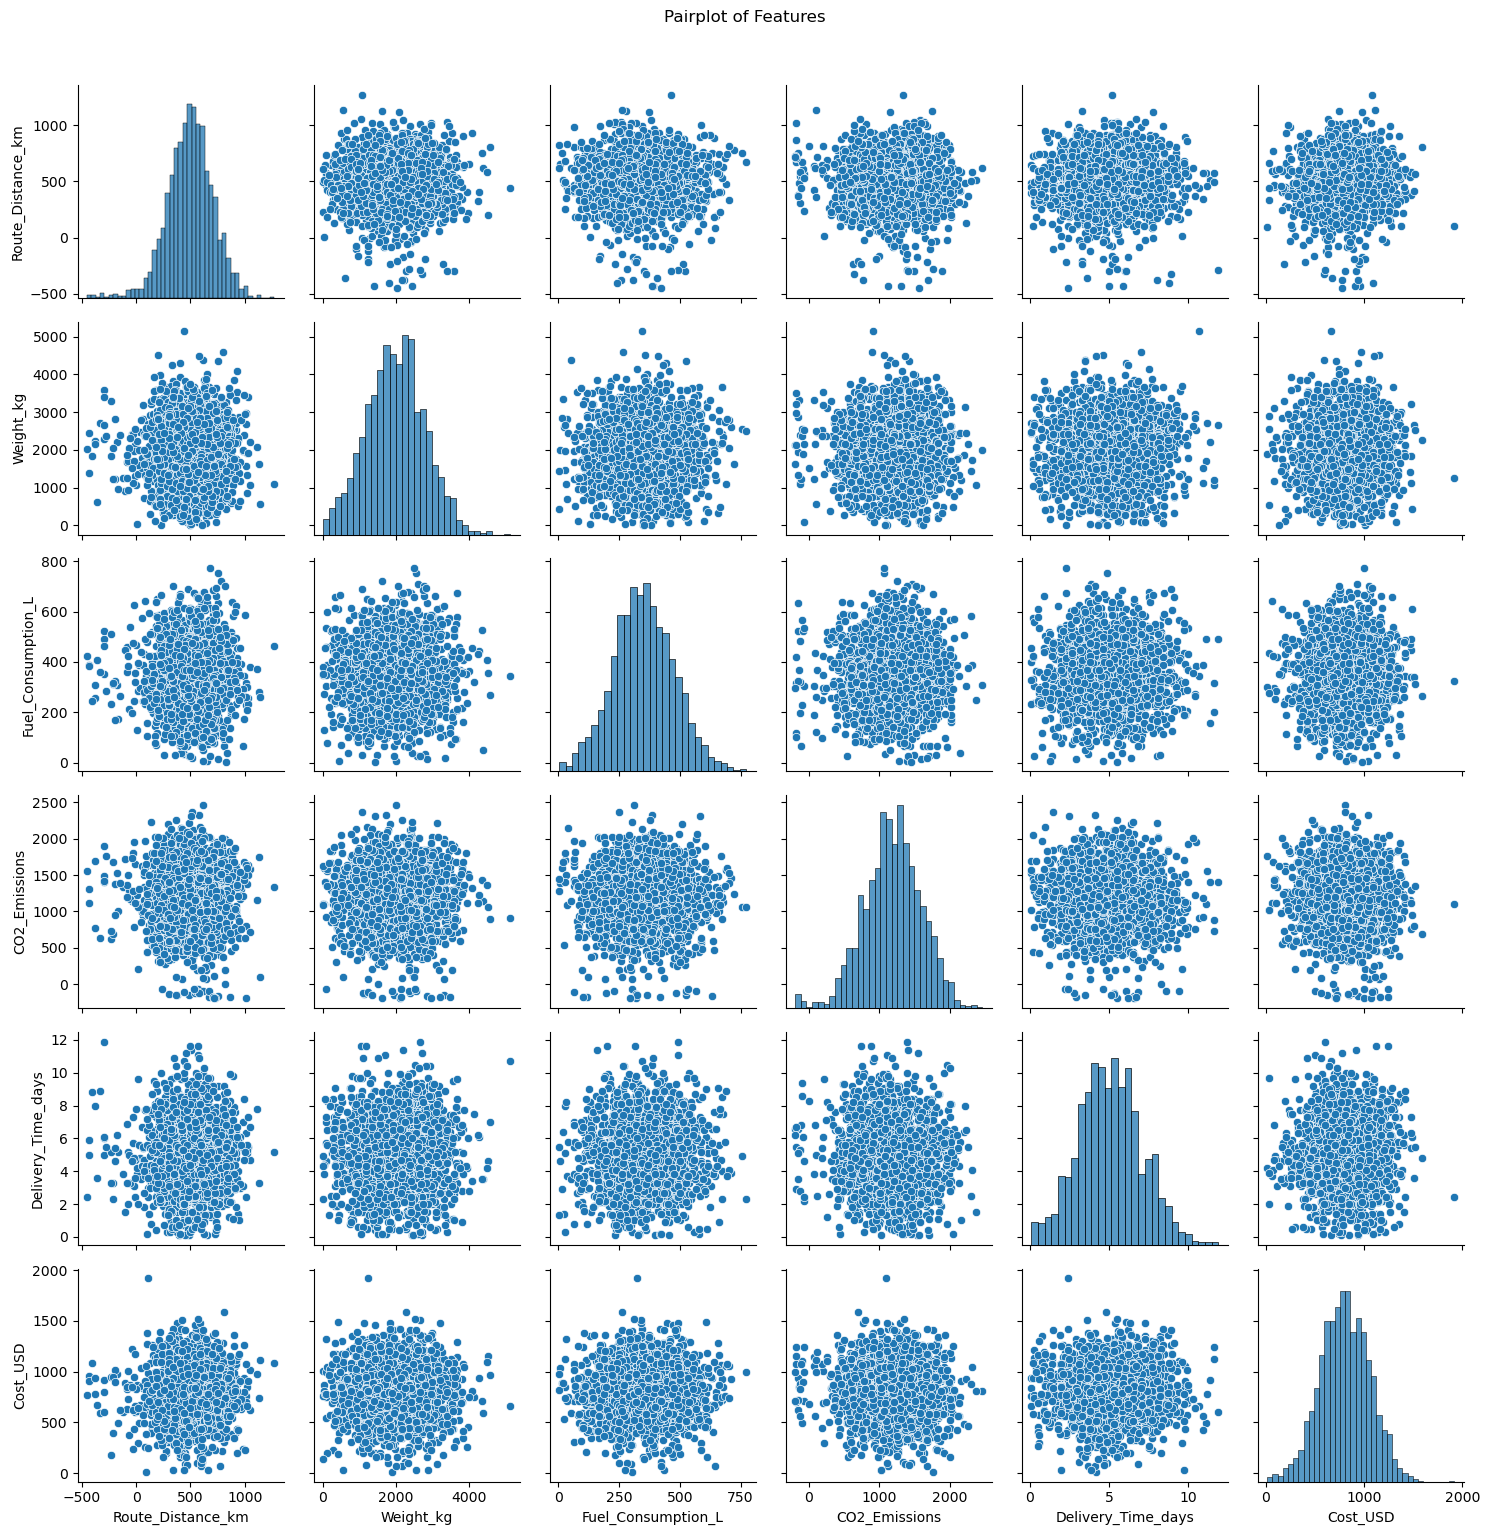

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a copy of the data to avoid modifying the original DataFrame
pairplot_data = data.copy()

# Drop Shipment_ID if it still exists, as it's not a useful feature for pairplot
if 'Shipment_ID' in pairplot_data.columns:
    pairplot_data.drop(columns=['Shipment_ID'], inplace=True)

# Generate the pairplot
sns.pairplot(pairplot_data)
plt.suptitle('Pairplot of Features', y=1.02) 
plt.tight_layout()
plt.show()

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Shipment_ID         2151 non-null   object 
 1   Route_Distance_km   2145 non-null   float64
 2   Weight_kg           2163 non-null   float64
 3   Transport_Mode      2023 non-null   object 
 4   Fuel_Type           2046 non-null   object 
 5   Fuel_Consumption_L  2001 non-null   float64
 6   CO2_Emissions       2129 non-null   float64
 7   Region              2084 non-null   object 
 8   Delivery_Time_days  2036 non-null   float64
 9   Cost_USD            2088 non-null   float64
dtypes: float64(6), object(4)
memory usage: 173.2+ KB


In [32]:
# 3. Summary Statistics
print(data.describe(include='all').T)

                     count unique      top freq         mean         std  \
Shipment_ID           2151   2136  SHP2876    2          NaN         NaN   
Route_Distance_km   2145.0    NaN      NaN  NaN   496.782424  212.912181   
Weight_kg           2163.0    NaN      NaN  NaN  1985.617772   796.01522   
Transport_Mode        2023      4     Rail  708          NaN         NaN   
Fuel_Type             2046      4   Diesel  552          NaN         NaN   
Fuel_Consumption_L  2001.0    NaN      NaN  NaN   350.440165   125.03808   
CO2_Emissions       2129.0    NaN      NaN  NaN  1184.387107  405.853756   
Region                2084      5    North  445          NaN         NaN   
Delivery_Time_days  2036.0    NaN      NaN  NaN     5.067633    2.007058   
Cost_USD            2088.0    NaN      NaN  NaN   802.460508  252.505254   

                      min       25%      50%       75%      max  
Shipment_ID           NaN       NaN      NaN       NaN      NaN  
Route_Distance_km  -451.0    36

In [33]:
# 4. Check for Missing Values
print(data.isnull().sum())

Shipment_ID            64
Route_Distance_km      70
Weight_kg              52
Transport_Mode        192
Fuel_Type             169
Fuel_Consumption_L    214
CO2_Emissions          86
Region                131
Delivery_Time_days    179
Cost_USD              127
dtype: int64


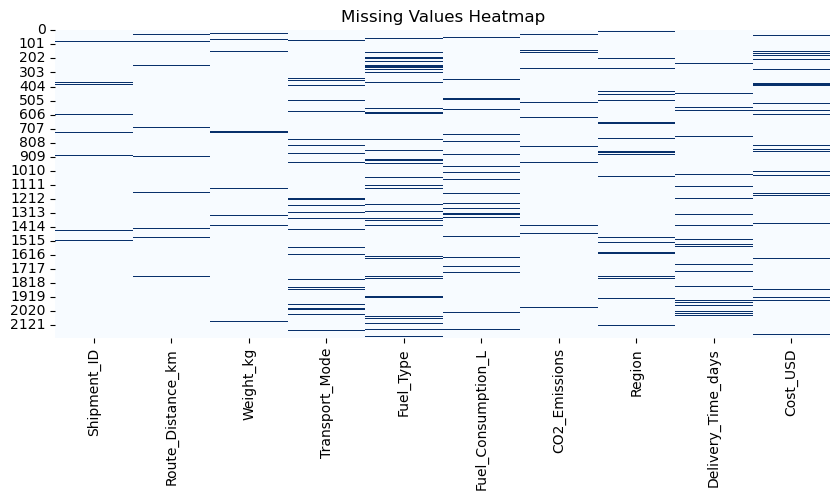

In [34]:
# Visualize missing values
plt.figure(figsize=(10, 4))
sns.heatmap(data.isnull(), cbar=False, cmap='Blues')
plt.title("Missing Values Heatmap")
plt.show()

In [35]:
data.dtypes

Shipment_ID            object
Route_Distance_km     float64
Weight_kg             float64
Transport_Mode         object
Fuel_Type              object
Fuel_Consumption_L    float64
CO2_Emissions         float64
Region                 object
Delivery_Time_days    float64
Cost_USD              float64
dtype: object

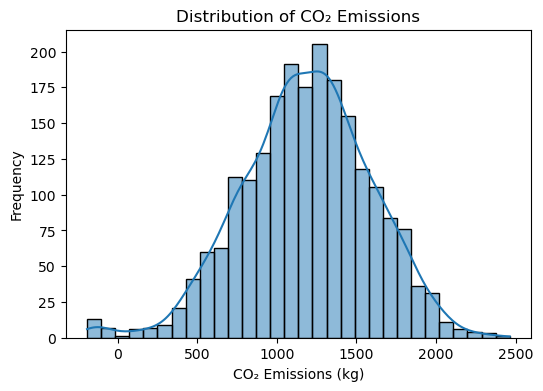

In [37]:
#  Distribution of Target Variable 
if 'CO2_Emissions' in data.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(data['CO2_Emissions'], bins=30, kde=True)
    plt.title("Distribution of CO₂ Emissions")
    plt.xlabel("CO₂ Emissions (kg)")
    plt.ylabel("Frequency")
    plt.show()

# 3. Data Preprocessing

In [38]:
# importing nessecery libraries

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [39]:
# 2. Remove duplicate rows
duplicates = data.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")
data = data.drop_duplicates()

Duplicate rows found: 14


In [40]:
# 3. Handle missing values
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

for col in cat_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

print("\nMissing values after imputation:")
print(data.isnull().sum())


Missing values after imputation:
Shipment_ID           0
Route_Distance_km     0
Weight_kg             0
Transport_Mode        0
Fuel_Type             0
Fuel_Consumption_L    0
CO2_Emissions         0
Region                0
Delivery_Time_days    0
Cost_USD              0
dtype: int64


In [41]:
# 5. HANDLE OUTLIERS (USING Z-SCORE)
import scipy.stats as stats

numeric_features = data.select_dtypes(include=np.number)
z_scores = np.abs(stats.zscore(numeric_features))
filtered_entries = (z_scores < 3).all(axis=1)
data = data[filtered_entries]
print(f"Shape after outlier removal: {data.shape}\n")

Shape after outlier removal: (2131, 10)



In [42]:
#4.Correct logical flaws (invalid or negative values)

data.loc[data["CO2_Emissions"] < 0, "CO2_Emissions"] = np.nan
data.loc[data["Route_Distance_km"] < 0, "Route_Distance_km"] = np.nan

In [43]:
# Re-impute those NaNs with median
data.loc[:, "CO2_Emissions"] = data["CO2_Emissions"].fillna(data["CO2_Emissions"].median())
data.loc[:, "Route_Distance_km"] = data["Route_Distance_km"].fillna(data["Route_Distance_km"].median())

In [44]:
# 6. Encode categorical variables
label_enc = LabelEncoder()
for col in cat_cols:
    data.loc[:, col] = label_enc.fit_transform(data[col])

In [45]:
# 8. FEATURE ENGINEERING


data['High_Emission_Flag'] = (data['CO2_Emissions'] > data['CO2_Emissions'].median()).astype(int)

data['Fuel_Efficiency'] = data['CO2_Emissions'] / (data['Route_Distance_km'] + 1e-5)

data['Cost_Efficiency'] = data['Cost_USD'] / ((data['Weight_kg'] * data['Route_Distance_km']) + 1e-5)

print("Feature engineering completed.\n")

Feature engineering completed.



In [ ]:
# 9. FEATURE SELECTION

if 'Shipment_ID' in data.columns:
    data.drop(columns=['Shipment_ID'], inplace=True)
print(f"Columns retained: {data.columns.tolist()}\n")

Columns retained: ['Route_Distance_km', 'Weight_kg', 'Transport_Mode', 'Fuel_Type', 'Fuel_Consumption_L', 'CO2_Emissions', 'Region', 'Delivery_Time_days', 'Cost_USD', 'High_Emission_Flag', 'Fuel_Efficiency', 'Cost_Efficiency']



In [47]:
# 11. SAVE CLEANED DATASET

data.to_csv("cleaned_supplychain_dataset.csv", index=False)
print(" Cleaned dataset saved as 'cleaned_supplychain_dataset.csv'")

 Cleaned dataset saved as 'cleaned_supplychain_dataset.csv'


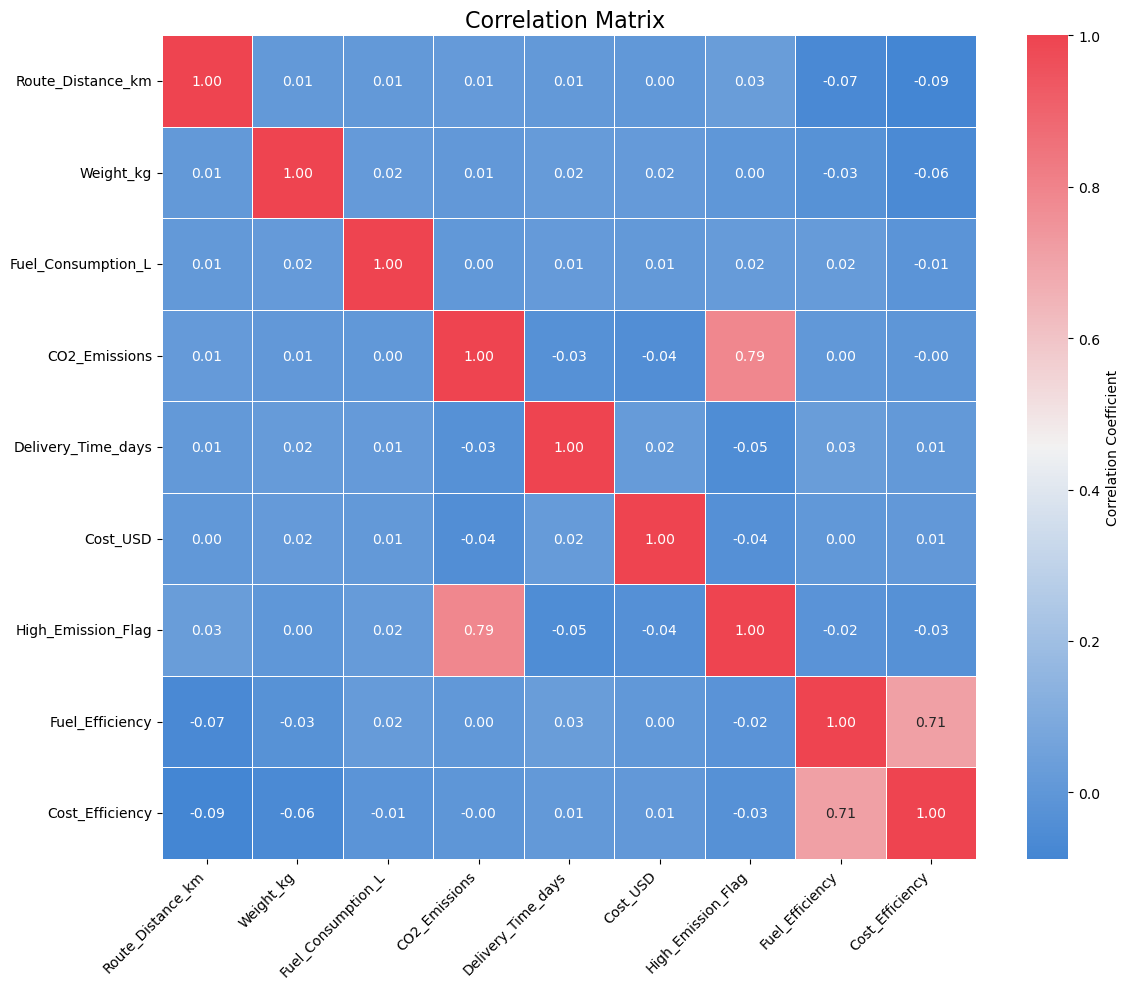

In [48]:

# Calculate the correlation matrix for numeric columns
numeric_data = data.select_dtypes(include=np.number)
correlation_matrix = numeric_data.corr()

# Create a custom diverging colormap for a pastel pink-blue theme
cmap = sns.diverging_palette(250, 10, s=80, l=55, as_cmap=True) # 250 for blue, 10 for pinkish/reddish

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,      
    cmap=cmap,       
    fmt=".2f",       
    linewidths=.5,   
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix ', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Data Splitting

In [49]:
from sklearn.model_selection import train_test_split

# 10. SPLIT DATA FOR MODELING

X = data.drop(['CO2_Emissions'], axis=1)
y = data['CO2_Emissions']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}\n")

Training set: (1704, 11), Test set: (427, 11)



In [ ]:
#Step 2. Basic Train-Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42  
)

In [51]:
#verifying the split
print(X_train.shape, X_test.shape)
print(y_train.describe(), "\n", y_test.describe())

(1704, 11) (427, 11)
count    1704.000000
mean     1197.330446
std       378.348289
min         7.420000
25%       949.130000
50%      1195.200000
75%      1452.510000
max      2365.640000
Name: CO2_Emissions, dtype: float64 
 count     427.000000
mean     1191.626721
std       380.254930
min        75.750000
25%       961.130000
50%      1195.200000
75%      1423.115000
max      2252.950000
Name: CO2_Emissions, dtype: float64


In [52]:
#saving the split dataset
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# 5. Algorithm Selection and Model Training

In [53]:
# Random Forest 
RND = 42
rf = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=RND, n_jobs=-1)

In [ ]:
# 4. MODEL DEFINITIONS (pipelines)

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])


In [55]:
#4. Train (Fit) Each Model on the Training Set
lr_pipeline.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [ ]:
# 5. CROSS-VALIDATED BENCHMARK (5-fold CV)

cv = KFold(n_splits=5, shuffle=True, random_state=RND)
scoring = "neg_root_mean_squared_error"  # RMSE


models = {
    "Linear Regression": lr_pipeline,
    "Random Forest": rf
}

cv_results = {}
print("\nCross-validated RMSE (5-fold):")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    rmse_scores = -scores  
    cv_results[name] = {"rmse_mean": rmse_scores.mean(), "rmse_std": rmse_scores.std()}
    print(f" {name:14s} -> RMSE: {rmse_scores.mean():.3f} \u00b1 {rmse_scores.std():.3f}")


Cross-validated RMSE (5-fold):
 Linear Regression -> RMSE: 1139.759 ± 1819.366
 Random Forest  -> RMSE: 66.328 ± 6.246


In [57]:
# 6. FIT MODELS ON TRAINING DATA

fitted_models = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    fitted_models[name] = model


Training Linear Regression ...

Training Random Forest ...


In [58]:
# 7. EVALUATE ON TEST SET

def eval_regression(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    return rmse, mae, r2

test_metrics = {}
print("\nTest set evaluation:")
for name, model in fitted_models.items():
    preds = model.predict(X_test)
    rmse, mae, r2 = eval_regression(y_test, preds)
    test_metrics[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    print(f" {name:14s} -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")


Test set evaluation:
 Linear Regression -> RMSE: 240.102, MAE: 195.808, R2: 0.600
 Random Forest  -> RMSE: 52.351, MAE: 30.795, R2: 0.981


In [59]:
# 8. COMPARISON TABLE & SAVE

comparison = []
for name in test_metrics:
    comparison.append({
        "Model": name,
        "CV_RMSE_mean": cv_results.get(name, {}).get("rmse_mean", np.nan),
        "CV_RMSE_std": cv_results.get(name, {}).get("rmse_std", np.nan),
        "Test_RMSE": test_metrics[name]["RMSE"],
        "Test_MAE": test_metrics[name]["MAE"],
        "Test_R2": test_metrics[name]["R2"]
    })
comp_df = pd.DataFrame(comparison).sort_values(by="Test_RMSE")
print("\nModel comparison (sorted by Test RMSE):\n", comp_df)
comp_df.to_csv("model_comparison.csv", index=False)
print("Saved comparison table to 'model_comparison.csv'")


Model comparison (sorted by Test RMSE):
                Model  CV_RMSE_mean  CV_RMSE_std   Test_RMSE    Test_MAE  \
1      Random Forest     66.327827     6.245862   52.350813   30.794681   
0  Linear Regression   1139.758948  1819.366220  240.102403  195.807875   

    Test_R2  
1  0.981002  
0  0.600367  
Saved comparison table to 'model_comparison.csv'


In [60]:
display(comp_df)

,Model,CV_RMSE_mean,CV_RMSE_std,Test_RMSE,Test_MAE,Test_R2
1,Random Forest,66.327827,6.245862,52.350813,30.794681,0.981002
0,Linear Regression,1139.758948,1819.366220,240.102403,195.807875,0.600367


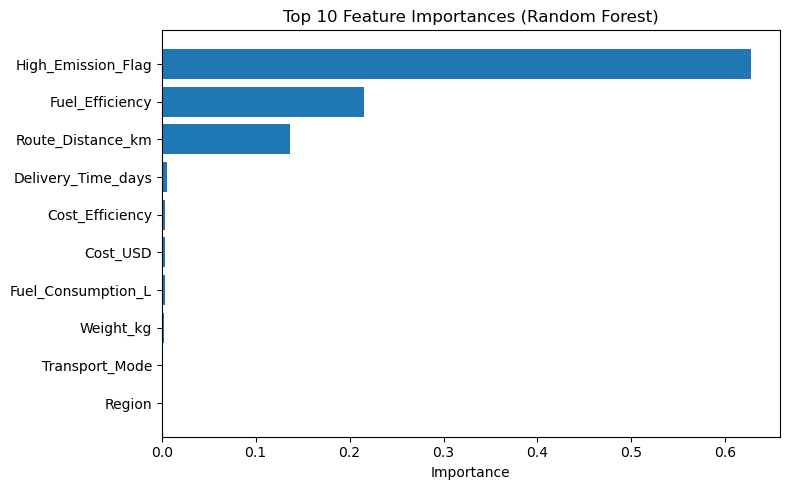

In [61]:
# Feature Importance from Random Forest
importances = rf.feature_importances_
features = X.columns
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(fi_df['Feature'].head(10)[::-1], fi_df['Importance'].head(10)[::-1])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# 7. Model Evaluation

In [ ]:
# X_train_full = X_train + X_valid 
X_full = pd.concat([X_train, X_valid]) if 'X_valid' in globals() else X_train
y_full = pd.concat([y_train, y_valid]) if 'y_valid' in globals() else y_train

final_model = fitted_models['Random Forest']  
final_model.fit(X_full, y_full)

RandomForestRegressor(max_depth=15, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [63]:
#Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [100,200,400],
    "max_depth": [6,10,15,None],
    "min_samples_leaf": [1,2,4]
}
rs = RandomizedSearchCV(final_model, param_dist, n_iter=30, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, random_state=42)
rs.fit(X_full, y_full)
best_final = rs.best_estimator_


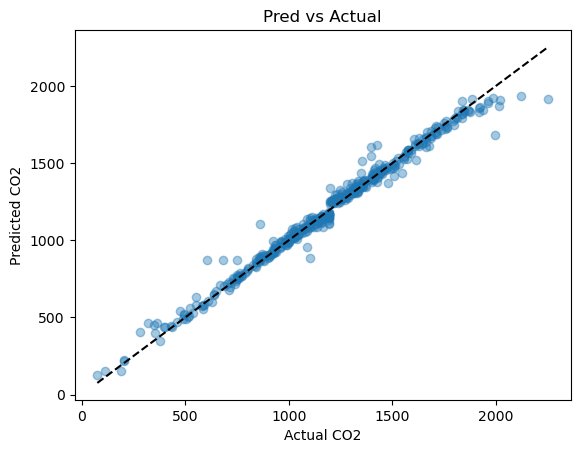

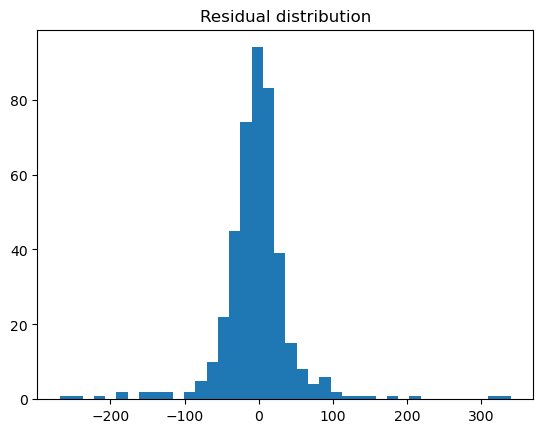

In [64]:
#Residual & error analysis
import matplotlib.pyplot as plt
preds = best_final.predict(X_test)
residuals = y_test - preds

plt.scatter(y_test, preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual CO2"); plt.ylabel("Predicted CO2"); plt.title("Pred vs Actual")
plt.show()

plt.hist(residuals, bins=40)
plt.title("Residual distribution")
plt.show()

# 8. Model Optimization and Final Model Evaluation on Test Data

In [65]:
#Generate Predictions on Test Data
y_pred = model.predict(X_test)

y_pred

array([1458.99078889,  992.27919617, 1006.65179457, 1697.1173    ,
       1668.8268    , 1262.99312222, 1438.93258333, 1011.25747137,
       1785.2586    , 1926.18756667, 1456.02611667,  757.22984286,
       1489.20217222, 1725.84996667, 1048.7887    ,  580.9853    ,
        951.27330278,  813.75993333,  233.63936667,  575.7775    ,
        855.96497778,  763.8524    , 1157.98405788, 1828.33632222,
       1354.69447365, 1621.72153573, 1101.99555458,  842.2487407 ,
       1155.74941865, 1497.9556119 ,  867.56396111, 1631.29928808,
       1011.63829167,  888.04407778, 1462.68976111, 1014.3322627 ,
       1341.84869167, 1320.85269841, 1428.24103333,  507.6636    ,
       1498.08436667, 1087.06394444, 1000.30410603, 1246.99613333,
       1028.80286667, 1792.48971333,  905.67936995,  915.12373333,
        795.95847778,  725.51256667, 1269.46      ,  889.97853333,
        998.59713333, 1082.91756667,  671.4204    , 1342.09275162,
       1797.17392   , 1867.27526667, 1252.74351429, 1380.68937

In [66]:
#Calculate Key Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

MAE: 30.79
MSE: 2740.61
RMSE: 52.35
R2 Score: 0.98


# 10. Model Deployment

In [ ]:
import streamlit as st
import pandas as pd
import joblib
import numpy as np
import io
import os
import math


@st.cache_resource
def load_model(path='model.joblib'):
    if not os.path.exists(path):
        return None
    return joblib.load(path)


@st.cache_data
def load_sample_features(path='X_train.csv'):
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    return df


def main():
    st.set_page_config(page_title='Carbon Emission Predictor', layout='wide')
    st.title('Carbon Emission Optimization — Prediction UI')
    st.write('Use below categories to predict carbon emissions')
    st.write('Road: 0, Rail: 1, Sea: 2, Air: 3')
    st.write('Petrol: 0, Diesel: 1, CNG: 2, Electric: 3')
    st.write(' North: 2, South: 0, East: 1, West: 3')
    # ---- Units mapping: simple heuristics to attach units to feature names ----
    units_map = {
        'route_distance': 'km',
        'distance': 'km',
        'km': 'km',
        'weight': 'kg',
        'kg': 'kg',
        'transport_mode': '',
        'fuel_type': '',
        'fuel_consumption': 'L',
        'fuel_consumption_l': 'L',
        'region': '',
        'delivery_time': 'days',
        'time_days': 'days',
        'cost': 'USD',
        'usd': 'USD',
        'high_emission_flag': '',
        'fuel_efficiency': '',
        'cost_efficiency': '',
        'emission': 'kgCO2',
        'carbon': 'kgCO2'
    }

    def get_unit(col_name: str) -> str:
        low = col_name.lower()
        for key, unit in units_map.items():
            if key in low:
                return unit
        return ''

    # Sidebar controls for tree calculation and model-output unit
    st.sidebar.header('Offset / Tree settings')
    model_output_unit = st.sidebar.selectbox('Model output unit', ['kgCO2', 'tCO2', 'custom'], index=0)
    custom_to_kg = 1.0
    if model_output_unit == 'tCO2':
        model_output_to_kg = 1000.0
    elif model_output_unit == 'kgCO2':
        model_output_to_kg = 1.0
    else:
        custom_text = st.sidebar.text_input('Custom unit (value -> kgCO2 factor)', '1.0')
        try:
            model_output_to_kg = float(custom_text)
        except Exception:
            model_output_to_kg = 1.0

    sequestration_per_tree = st.sidebar.number_input('Sequestration per tree (kg CO2 / year)', value=21.77)
    sequestration_years = st.sidebar.number_input('Years trees will sequester (years)', value=20)

    model = load_model('model.joblib')
    if model is None:
        st.error('Model file `model.joblib` not found in the project directory.')
        st.stop()

    sample_df = load_sample_features('X_train.csv')
    if sample_df is None:
        st.warning('`X_train.csv` not found — you can upload a CSV in Batch mode or enter values manually.')

    st.sidebar.header('Prediction Mode')
    mode = st.sidebar.selectbox('Mode', ['Single input', 'Batch upload'])

    # Determine feature names from sample_df if available, else allow user to provide/upload
    if sample_df is not None:
        feature_names = list(sample_df.columns)
    else:
        feature_names = None

    if mode == 'Single input':
        st.header('Single prediction')
        st.write('Enter feature values to predict for a single shipment/route.')

        user_input = {}
        if feature_names is not None:
            for col in feature_names:
                # Choose sensible defaults from sample_df if possible
                col_series = sample_df[col]
                unit = get_unit(col)
                label = f"{col} ({unit})" if unit else col
                if pd.api.types.is_numeric_dtype(col_series):
                    default = float(col_series.median())
                    user_input[col] = st.number_input(label, value=default, format='%f')
                else:
                    # treat as string/categorical
                    user_input[col] = st.text_input(label, value=str(col_series.mode().iat[0]) if not col_series.mode().empty else '')
        else:
            st.write('No feature list found. Upload a sample CSV or enter comma-separated feature names below.')
            cols_text = st.text_input('Feature names (comma-separated)', '')
            if cols_text:
                feature_names = [c.strip() for c in cols_text.split(',') if c.strip()]
                for col in feature_names:
                    user_input[col] = st.text_input(col)

        if st.button('Predict single'):
            if not feature_names:
                st.error('Feature names unknown. Provide a sample or enter names first.')
            else:
                input_df = pd.DataFrame([user_input], columns=feature_names)
                try:
                    preds = model.predict(input_df)
                    # handle multi-output models; take first output if array-like
                    pred_value = float(np.asarray(preds).ravel()[0])
                    st.success(f'Prediction: {pred_value} {model_output_unit}')
                    # Calculate trees needed to offset predicted emission (converted to kgCO2)
                    total_kg = pred_value * float(model_output_to_kg)
                    per_tree_total = float(sequestration_per_tree) * float(sequestration_years)
                    if per_tree_total > 0:
                        trees_needed = math.ceil(total_kg / per_tree_total)
                    else:
                        trees_needed = None
                    if trees_needed is not None:
                        st.info(f'Estimated trees to plant to offset this prediction: {trees_needed} trees \n(assumes {sequestration_per_tree} kgCO2/year per tree for {sequestration_years} years)')
                    st.write('Input')
                    st.dataframe(input_df)
                except Exception as e:
                    st.error(f'Prediction failed: {e}')

    else:
        st.header('Batch prediction')
        st.write('Upload a CSV (same features used by the model). Or use the included `X_test.csv` if present.')
        uploaded = st.file_uploader('Upload CSV', type=['csv'])
        use_sample = st.button('Use included `X_test.csv`')

        batch_df = None
        if uploaded is not None:
            try:
                batch_df = pd.read_csv(uploaded)
            except Exception as e:
                st.error(f'Failed to read uploaded CSV: {e}')
        elif use_sample:
            sample_path = 'X_test.csv'
            if os.path.exists(sample_path):
                batch_df = pd.read_csv(sample_path)
            else:
                st.error('`X_test.csv` not found in project directory.')

        if batch_df is not None:
            st.write('Preview of uploaded data:')
            st.dataframe(batch_df.head())

            if feature_names is not None:
                # Ensure columns align — reindex or warn
                missing = [c for c in feature_names if c not in batch_df.columns]
                if missing:
                    st.warning(f'Missing columns in uploaded file: {missing}. Attempting to predict with available columns.')
                # Reindex to feature_names where possible
                try:
                    input_for_model = batch_df.reindex(columns=feature_names)
                except Exception:
                    input_for_model = batch_df
            else:
                input_for_model = batch_df

            if st.button('Run batch prediction'):
                try:
                    preds = model.predict(input_for_model.fillna(0))
                    out = input_for_model.copy()
                    # flatten preds to 1-D
                    flat_preds = np.asarray(preds).ravel()
                    out['prediction'] = flat_preds
                    # convert to kgCO2 then compute trees needed per row
                    total_kg_arr = flat_preds * float(model_output_to_kg)
                    per_tree_total = float(sequestration_per_tree) * float(sequestration_years)
                    if per_tree_total > 0:
                        trees_arr = [math.ceil(x / per_tree_total) for x in total_kg_arr]
                    else:
                        trees_arr = [None] * len(total_kg_arr)
                    out['trees_needed'] = trees_arr
                    st.success('Batch prediction complete')
                    st.dataframe(out.head())

                    # Download button
                    csv_bytes = out.to_csv(index=False).encode('utf-8')
                    st.download_button('Download predictions CSV', data=csv_bytes, file_name='predictions.csv', mime='text/csv')
                except Exception as e:
                    st.error(f'Batch prediction failed: {e}')

    # Optional: feature importance if available
    st.sidebar.header('Model info')
    if hasattr(model, 'feature_importances_') and sample_df is not None:
        try:
            fi = model.feature_importances_
            fi_df = pd.DataFrame({'feature': sample_df.columns, 'importance': fi})
            fi_df = fi_df.sort_values('importance', ascending=False)
            st.sidebar.write('Feature importances')
            st.sidebar.bar_chart(fi_df.set_index('feature'))
        except Exception:
            st.sidebar.write('Could not show feature importances for this model.')


if __name__ == '__main__':
    main()

#    python -m streamlit run app.py
#"Provide shipment details below. The model predicts CO2 emissions (kg) and suggests number of trees to plant to offset the emission (approx per year).\nRoad: 0, Rail: 1, Sea: 2, Air: 3\nPetrol: 0, Diesel: 1, CNG: 2, Electric: 3\n North: 2, South: 0, East: 1, West: 3"